In [17]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt

In [3]:
# 하이퍼파라미터 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64
N_EPOCHS = 20

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [4]:
import os
print(os.getcwd())

d:\sy\code


In [5]:
# 데이터세트 디렉토리 설정
original_dir = '../PCB_imgs/all'
original_dataset = ImageFolder(root=original_dir, transform=transform)

# 데이터세트 DataLoader로 변환
original_loader = DataLoader(original_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 분할
file_paths = [img[0] for img in original_dataset.imgs]
targets = original_dataset.targets

train_images, test_images, train_targets, test_targets = train_test_split(
    file_paths, targets, stratify=targets, test_size=0.2, random_state=124
)

train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

In [6]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


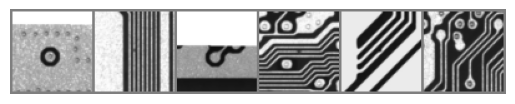

OK    NG    OK    NG    NG    OK   


In [33]:
classes = ('NG', 'OK')

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 축 숨기기
    plt.show()

# 이미지를 무작위로 가져오기
dataiter = iter(original_loader)
images, labels = next(dataiter)

# 6개의 이미지와 레이블만 가져오기
images = images[:6]  # 첫 6개 이미지
labels = labels[:6]  # 첫 6개 레이블

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))  # labels의 길이에 따라 반복

In [44]:
# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [8]:
# # 데이터 증강 정의
# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

In [9]:
# 데이터세트 인스턴스 생성
# train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

In [45]:
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name in ['vgg16', 'inception']:
            return 25088  # VGG16의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Sigmoid 제거
        # x = torch.sigmoid(self.fc2(x))
        return x

In [47]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(device)

In [48]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [49]:
# 평가 함수 정의
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.view(-1), targets)
            total_loss += loss.item()
            
            predicted = (outputs.view(-1) > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [50]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5310, Train Accuracy: 0.7385, Val Loss: 0.3989, Val Accuracy: 0.7749
Epoch [2/20], Train Loss: 0.3600, Train Accuracy: 0.8162, Val Loss: 0.3059, Val Accuracy: 0.8625
Epoch [3/20], Train Loss: 0.3046, Train Accuracy: 0.8710, Val Loss: 0.2564, Val Accuracy: 0.8884
Epoch [4/20], Train Loss: 0.2469, Train Accuracy: 0.8964, Val Loss: 0.2735, Val Accuracy: 0.8984
Epoch [5/20], Train Loss: 0.2064, Train Accuracy: 0.9203, Val Loss: 0.2016, Val Accuracy: 0.9323
Epoch [6/20], Train Loss: 0.1663, Train Accuracy: 0.9373, Val Loss: 0.2459, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.1446, Train Accuracy: 0.9492, Val Loss: 0.2505, Val Accuracy: 0.9104
Epoch [8/20], Train Loss: 0.1738, Train Accuracy: 0.9363, Val Loss: 0.2346, Val Accuracy: 0.9124
Epoch [9/20], Train Loss: 0.1311, Train Accuracy: 0.9482, Val Loss: 0.2559, Val Accuracy: 0.9124
Epoch [10/20], Train Loss: 0.1296, Train Accuracy: 0.9542, Val Loss: 0.2686, Val Accuracy: 0.9064
Epoch [11/20], Train Loss: 0.

In [52]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2449, Test Accuracy: 0.9283


mobilenet 모델

In [23]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [24]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [34]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.0093, Train Accuracy: 0.9965, Val Loss: 0.4605, Val Accuracy: 0.9064
Epoch [2/20], Train Loss: 0.0150, Train Accuracy: 0.9955, Val Loss: 0.4782, Val Accuracy: 0.8964
Epoch [3/20], Train Loss: 0.0181, Train Accuracy: 0.9935, Val Loss: 0.4725, Val Accuracy: 0.9084
Epoch [4/20], Train Loss: 0.0104, Train Accuracy: 0.9965, Val Loss: 0.4673, Val Accuracy: 0.9104
Epoch [5/20], Train Loss: 0.0141, Train Accuracy: 0.9960, Val Loss: 0.4270, Val Accuracy: 0.9263
Epoch [6/20], Train Loss: 0.0141, Train Accuracy: 0.9950, Val Loss: 0.4540, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.0264, Train Accuracy: 0.9945, Val Loss: 0.4063, Val Accuracy: 0.9183
Epoch [8/20], Train Loss: 0.0156, Train Accuracy: 0.9955, Val Loss: 0.3588, Val Accuracy: 0.9283
Epoch [9/20], Train Loss: 0.0069, Train Accuracy: 0.9980, Val Loss: 0.3427, Val Accuracy: 0.9363
Epoch [10/20], Train Loss: 0.0041, Train Accuracy: 0.9990, Val Loss: 0.3589, Val Accuracy: 0.9263
Epoch [11/20], Train Loss: 0.

In [35]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3467, Test Accuracy: 0.9379


데이터 증강을 해보자..  
일단 훈련 손실값은 계속 낮아지지만 검증 손실값이 오르락 내리락하는군..

In [36]:
# # 데이터 증강 정의
aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

# 데이터세트 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [38]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [39]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5816, Train Accuracy: 0.6927, Val Loss: 0.4305, Val Accuracy: 0.7789
Epoch [2/20], Train Loss: 0.4323, Train Accuracy: 0.7953, Val Loss: 0.3627, Val Accuracy: 0.8008
Epoch [3/20], Train Loss: 0.3643, Train Accuracy: 0.8362, Val Loss: 0.3355, Val Accuracy: 0.8466
Epoch [4/20], Train Loss: 0.3286, Train Accuracy: 0.8421, Val Loss: 0.2983, Val Accuracy: 0.8865
Epoch [5/20], Train Loss: 0.2895, Train Accuracy: 0.8685, Val Loss: 0.2763, Val Accuracy: 0.8805
Epoch [6/20], Train Loss: 0.2811, Train Accuracy: 0.8835, Val Loss: 0.2569, Val Accuracy: 0.9024
Epoch [7/20], Train Loss: 0.2413, Train Accuracy: 0.8994, Val Loss: 0.2505, Val Accuracy: 0.9143
Epoch [8/20], Train Loss: 0.2324, Train Accuracy: 0.9034, Val Loss: 0.2712, Val Accuracy: 0.8904
Epoch [9/20], Train Loss: 0.2013, Train Accuracy: 0.9213, Val Loss: 0.2594, Val Accuracy: 0.9044
Epoch [10/20], Train Loss: 0.1833, Train Accuracy: 0.9258, Val Loss: 0.2639, Val Accuracy: 0.9044
Epoch [11/20], Train Loss: 0.

In [40]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2799, Test Accuracy: 0.9092


resnet50  
Epoch [20/20], Train Loss: 0.0688, Train Accuracy: 0.9746, Val Loss: 0.2381, Val Accuracy: 0.9303    

mobilenet   
Epoch [20/20], Train Loss: 0.0012, Train Accuracy: 0.9995, Val Loss: 0.4009, Val Accuracy: 0.9243    

mobilenet 데이터 증강 후  
Epoch [20/20], Train Loss: 0.1009, Train Accuracy: 0.9622, Val Loss: 0.3000, Val Accuracy: 0.9124

#### NG 이미지 특성 확인해보기  

In [14]:
# ng 폴더내 이미지가 왜 결함이 있는지 이름에 따라 나눠볼 수 있을 듯.
# 먼저 파일이름으로 몇종류의 결함이 있는지 확인해보기

# 이미지 명이 '결함명 (이미지 번호).bmp.bmp' 또는 '결함명_이미지 번호.bmp.bmp' 로 되어있는 것을 확인.
# 적절한 결함명만 추출해보자 (중복 제외)
import os
import re

# NG 폴더 경로
ng_root = '../PCB_imgs/all/NG/'

# 파일 이름에서 결함명 추출 함수
def extract_defect_names(folder_path):
    # 폴더 내 파일 리스트 불러오기
    files = os.listdir(folder_path)
    
    # 결함명을 저장할 집합 (중복 방지, 소문자로 변환)
    defect_names = set()
    
    # 파일명 패턴 분석 (결함명 추출)
    # 결함명(숫자) 또는 결함명_숫자 형식의 파일명 대응
    pattern = re.compile(r'([가-힣a-zA-Z]+)[_\s]?\(?\d+\)?\.bmp\.bmp')

    for file_name in files:
        match = pattern.match(file_name)
        if match:
            defect_name = match.group(1).lower()  # 결함명을 소문자로 변환하여 중복 제거
            defect_names.add(defect_name)
    
    return defect_names

# NG 폴더에서 결함명 추출
defect_names = extract_defect_names(ng_root)
print(defect_names)


{'eemool', 'open', 'nogwang', 'miboo', 'miboosik', 'dust', 'pinhole', 'milchack', 'lvh', 'nick', 'island', 'chui', 'short', 'bichim', 'pyomyun', 'scratch'}


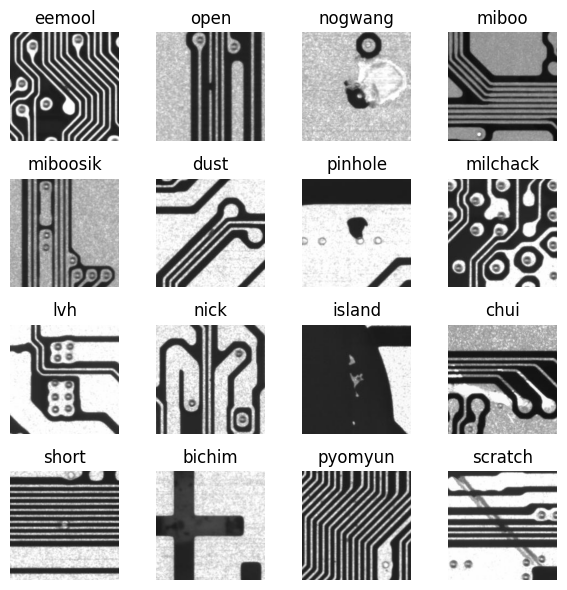

{'eemool', 'open', 'nogwang', 'miboo', 'miboosik', 'dust', 'pinhole', 'milchack', 'lvh', 'nick', 'island', 'chui', 'short', 'bichim', 'pyomyun', 'scratch'}


In [139]:
# ng 폴더내 이미지가 왜 결함이 있는지 이름에 따라 나눠볼 수 있을 듯.
# 먼저 파일이름으로 몇종류의 결함이 있는지 확인해보기

# 이미지 명이 '결함명 (이미지 번호).bmp.bmp' 또는 '결함명_이미지 번호.bmp.bmp' 로 되어있는 것을 확인.
# 적절한 결함명만 추출해보자 (중복 제외)
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt

# NG 폴더 경로
ng_root = '../PCB_imgs/all/NG/'

# 파일 이름에서 결함명 추출 함수
def extract_defect_names(folder_path):
    # 폴더 내 파일 리스트 불러오기
    files = os.listdir(folder_path)
    
    # 결함명을 저장할 집합 (중복 방지, 소문자로 변환)
    defect_names = set()
    
    # 파일명 패턴 분석 (결함명 추출)
    pattern = re.compile(r'([a-zA-Z]+)[_\s]?\(?\d+\)?\.bmp\.bmp')

    for file_name in files:
        match = pattern.match(file_name)
        if match:
            defect_name = match.group(1).lower()  # 결함명을 소문자로 변환
            defect_names.add(defect_name)
    
    return defect_names

# 결함명과 해당 이미지 목록을 저장할 딕셔너리 생성
defect_images = {}

# NG 폴더에서 결함명 추출 및 해당 이미지 수집
defect_names = extract_defect_names(ng_root)

for defect in defect_names:
    # 결함명으로 해당하는 이미지 파일 목록 생성
    defect_images[defect] = [f for f in os.listdir(ng_root) if defect in f]

# 각 결함 유형에서 랜덤으로 하나의 이미지를 시각화 (4x4)
def visualize_defect_images(defect_images):
    # 최대 16개 이미지
    images_to_show = []
    for defect, images in defect_images.items():
        if len(images) > 0: 
            # 랜덤으로 하나의 이미지 선택
            image_file = random.choice(images)
            image_path = os.path.join(ng_root, image_file)

            images_to_show.append((defect, Image.open(image_path)))

    # 4x4 그리드로 시각화
    plt.figure(figsize=(6, 6))
    num_images = min(16, len(images_to_show))
    for i in range(num_images):
        defect, image = images_to_show[i]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        plt.title(defect)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 결함 이미지 시각화
visualize_defect_images(defect_images)
print(defect_names)

eemool: 아마도 **"이물"**을 의미할 수 있습니다. 이물질이 PCB 위에 남아 있는 결함으로, 외부 오염 또는 제조 과정에서 발생할 수 있는 먼지, 파편 등을 말합니다.  

open: **"오픈 회로"**를 의미합니다. PCB의 트레이스가 단절되거나 연결되지 않아 회로가 열려 있는 상태로, 전류가 흐르지 않는 결함입니다.  

nogwang: 아마도 **"노광"**을 의미할 수 있습니다. 이는 PCB 제조 시 노광(사진 이미지 처리 과정) 문제로 인해 발생하는 결함을 뜻할 수 있습니다.  

miboo: **"미부"**로 추정됩니다. **미부(미부착)**는 특정 부품이나 소재가 제대로 부착되지 않은 경우를 의미할 수 있습니다.  

miboosik: **"미부식"**으로 보입니다. 미부식은 PCB 표면이 제대로 부식되지 않았거나 부식이 부족한 상태를 의미할 수 있습니다.  

dust: **"먼지"**를 뜻합니다. 이물질이 PCB에 붙어 있는 결함으로, 먼지로 인한 표면 오염을 의미할 수 있습니다.  

pinhole: "핀홀" 결함은 매우 작은 구멍이 PCB 트레이스 또는 납땜된 부위에 생긴 결함을 의미합니다. 제조 공정 중 불완전한 납땜이나 불균일한 코팅으로 인해 발생할 수 있습니다.  

milchack: "밀착" 문제로 보입니다. PCB 부품이 제대로 밀착되지 않았을 때 발생하는 결함일 수 있습니다.  
 
lvh: **"LVH"**는 Laser Via Hole의 약어일 가능성이 높습니다. 이는 PCB에서 레이저로 만든 미세 구멍(Via) 관련 결함을 의미할 수 있습니다.  

nick: **"니크"**는 작은 긁힘이나 칩 등이 발생한 결함을 의미할 수 있습니다. 물리적 손상으로 인한 표면 손상일 수 있습니다.  

island: "섬" 결함은 PCB의 전도층에서 트레이스가 끊어져 섬처럼 남아 있는 결함을 나타낼 수 있습니다.  

chui: **"취"**는 아마도 취부(납땜 결함)와 관련 있을 수 있습니다. 납땜이 잘못되거나 불완전하게 이루어진 결함을 의미할 수 있습니다.  

short: **"쇼트"**는 단락 결함입니다. 두 개의 전기 회로가 의도치 않게 연결되어 단락(short)이 발생하는 상황을 의미합니다.  

bichim: **"비침"**으로, PCB 기판의 패턴이 잘못 인쇄되어 아래층이 비치는 결함을 의미할 수 있습니다.  

pyomyun: "표면" 결함으로 보입니다. PCB 표면에 균열, 긁힘 등이 발생한 결함을 의미할 수 있습니다.  

scratch: "스크래치" 결함은 PCB 표면에 긁힘이나 손상이 생긴 결함을 의미합니다.  

#### .bmp vs .png 확장자?    
  
1. 파일 형식 및 압축  
BMP (Bitmap): BMP는 비압축 이미지 형식입니다. 이는 파일 크기가 크고, 이미지 데이터가 픽셀 단위로 저장되기 때문에 원본 이미지 품질이 손실되지 않습니다. 그러나, 이로 인해 파일 크기가 상당히 커질 수 있습니다.  
PNG (Portable Network Graphics): PNG는 무손실 압축 이미지 형식입니다. 이는 이미지 품질을 유지하면서도 파일 크기를 줄일 수 있습니다. PNG는 투명도를 지원하고, 더 다양한 색상 정보를 저장할 수 있습니다.  

2. 투명도  
BMP: 투명도를 지원하지 않습니다.  
PNG: 알파 채널을 지원하여 투명한 배경을 가진 이미지를 생성할 수 있습니다.  

4. png를 선택한 이유  
무손실 압축: 모델 훈련 시 품질 손실 없이 데이터를 사용할 수 있다.  
투명도 지원: 필요에 따라 배경을 제거한 이미지를 사용할 수 있습니다. 이는 특정 분류 작업에서 유용할 수 있습니다.  
즉, 압축을 하되 손실이 없는 무손실 압축을 하여 파일 크기를 줄여 주는 png를 선택하여 이진 분류 모델을 만드는 것이 효율적이다.  

In [21]:
# 각 이미지 크기가 다를 수 있으므로 일관된 크기로 리사이징 진행
# CNN 모델에서 사용할 수 있는 적절한 크기로 진행 (256 * 256)
from PIL import Image
import os

def convert_image_size(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    resized_images_num = 0  # 리사이즈된 이미지 수를 저장할 변수
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.bmp'):
            img = Image.open(os.path.join(input_dir, file_name))
            # 256 * 256으로 리사이징
            img = img.resize((256, 256))  
            # 리사이즈된 이미지를 output_dir에 PNG 형식으로 저장 (확장자 변경)
            png_file_name = file_name[:-4] + '.png'  # 확장자 변경
            img.save(os.path.join(output_dir, png_file_name), format='PNG')  
            resized_images_num += 1  # 리사이즈된 이미지 수 증가

    return resized_images_num  # 리사이즈된 이미지 수 반환

In [25]:
# NG 이미지 리사이징
input_dir = '../PCB_imgs/all/NG/'  
output_dir = '../PCB_imgs/all/resize/NG/'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1840


In [26]:
# OK 이미지 리사이징
input_dir = '../PCB_imgs/all/OK/'  
output_dir = '../PCB_imgs/all/resize/OK'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1298


#### 정규화 (Normalization)  
- 픽셀 값 정규화  
이미지의 픽셀 값은 0~255의 범위를 가지기 때문에 신경망의 빠르고 효율적인 학습을 위해  
각 픽셀값을 0~1 사이의 범위로 정규화 진행

방법1: ToTensor()사용 -> 자동으로 정규화  
방법2: Normalize(/255) 사용 -> 수동으로 정규화  

In [27]:
import torch
from torchvision import datasets, transforms

IMAGE_SIZE = 256
BATCH_SIZE = 32

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
    # 위에서 resize는 진행했으므로 이 부분에서는 생략
    # transforms.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


torch.Size([32, 3, 256, 256])  
-> 이미지가 컬러로 표시..  
-> 육안 상, 흑백이미지로 보이는 경우 어떻게 모델훈련을 진행하면 좋을까?  

-> 사용하려는 모델이 RGB에 최적화 되어있다면(VGG, Resnet 등) RGB로!  
-> 아니라면 흑백으로 적용하여 효율적인 시간 절약을 해보자.


In [33]:
# 라이브러리 임포트
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [36]:
# 리사이징 된 이미지를 train, test, validation으로 나누기 (train 0.8 / test 0.2 -> train 0.64 / val 0.16 / test 0.2)
# 데이터셋 디렉토리 설정
original_dir = '../PCB_imgs/all/resize/'
original_dataset = datasets.ImageFolder(root=original_dir, transform=transform)

# 데이터 분할
file_paths = [img[0] for img in original_dataset.imgs]
targets = original_dataset.targets

train_images, test_images, train_targets, test_targets = train_test_split(
    file_paths, targets, stratify=targets, test_size=0.2, random_state=124
)

train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

# 새 디렉토리 생성
new_dirs = ['train', 'validation', 'test']
for dir_name in new_dirs:
    os.makedirs(os.path.join(original_dir, dir_name, 'NG'), exist_ok=True)
    os.makedirs(os.path.join(original_dir, dir_name, 'OK'), exist_ok=True)

# 이미지 이동 함수
def move_images(df, split):
    for index, row in df.iterrows():
        src_path = row['file_paths']
        # 타겟 클래스에 따라 목적지 경로 설정
        target_class = 'NG' if row['targets'] == 0 else 'OK'
        dest_path = os.path.join(original_dir, split, target_class, os.path.basename(src_path))
        shutil.copy(src_path, dest_path)  # 이미지 이동

# 이미지 이동
move_images(train_df, 'train')
move_images(validation_df, 'validation')
move_images(test_df, 'test')

print("이미지 이동 완료")

이미지 이동 완료


In [38]:
display(train_df)
display(validation_df)
display(test_df)

,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok_859.bmp.png,1
1,../PCB_imgs/all/resize/NG\nick (64).bmp.png,0
2,../PCB_imgs/all/resize/NG\eemool (211).bmp.png,0
3,../PCB_imgs/all/resize/OK\ok_1362.bmp.png,1
4,../PCB_imgs/all/resize/NG\nick (122).bmp.png,0
...,...,...
2003,../PCB_imgs/all/resize/NG\Dust_2697.bmp.png,0
2004,../PCB_imgs/all/resize/NG\dust (93).bmp.png,0
2005,../PCB_imgs/all/resize/OK\ok_784.bmp.png,1
2006,../PCB_imgs/all/resize/NG\eemool (285).bmp.png,0


,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok (406).bmp.png,1
1,../PCB_imgs/all/resize/NG\Dust_Nick_2100.bmp.png,0
2,../PCB_imgs/all/resize/NG\Dust_2706.bmp.png,0
3,../PCB_imgs/all/resize/OK\ok_551.bmp.png,1
4,../PCB_imgs/all/resize/OK\ok (15).bmp.png,1
...,...,...
497,../PCB_imgs/all/resize/NG\Nick_2425.bmp.png,0
498,../PCB_imgs/all/resize/NG\eemool1 (32).bmp.png,0
499,../PCB_imgs/all/resize/OK\ok (635).bmp.png,1
500,../PCB_imgs/all/resize/OK\ok_436.bmp.png,1


,file_paths,targets
0,../PCB_imgs/all/resize/OK\ok_547.bmp.png,1
1,../PCB_imgs/all/resize/NG\miboo (1641).bmp.png,0
2,../PCB_imgs/all/resize/OK\ok_731.bmp.png,1
3,../PCB_imgs/all/resize/NG\nick (49).bmp.png,0
4,../PCB_imgs/all/resize/NG\Dust_Nick_2127.bmp.png,0
...,...,...
623,../PCB_imgs/all/resize/NG\miboo (1614).bmp.png,0
624,../PCB_imgs/all/resize/OK\ok_991.bmp.png,1
625,../PCB_imgs/all/resize/NG\Short_60.bmp.png,0
626,../PCB_imgs/all/resize/NG\short_2755.bmp.png,0


In [37]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


이미지 증강 없이 훈련 진행해보기.  
적절한 모델은 어떻게 찾을까?  
데이터의 특성  
1. 결함 종류가 이물질, 오픈 회로, 광없음, 미부착, 미부식, 먼지, 핀홀, 밀착, 레이저로 인해 생긴 미세 구멍, 작은 긁힘, 섬, 잘못된 납땜,  
두 전기 회로의 의도치 않은 연결로 인한 단락현상, PCB 기반의 패턴이 잘못 인쇄되어 아래층이 비치는 현상, 표면에 균열 / 긁힘 등이 있는 현상, 스크래치가 있는 현상 등으로 다양하다.  
2. 결함 이미지가 1840개, 정상 이미지가 1240개로 총 3180개의 소규모 이미지 데이터 세트이다.  

[계획]  
1. 간단한 CNN 모델을 만들어서 훈련을 진행.  
2. 모델의 성능이 좋지 않다면 사전 훈련 모델을 사용해서 모델 학습을 진행.    
3. 데이터의 과적합이 발생한다면, 데이터 증강 또는 오버샘플링 등을 적용해보자.  

In [53]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
IMAGE_SIZE = 256

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 훈련, 테스트, 검증 데이터의 경로 지정
train_dir = '../PCB_imgs/all/resize/train/'
test_dir = '../PCB_imgs/all/resize/test/'
val_dir = '../PCB_imgs/all/resize/validation/'

# DataLoader 정의
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [71]:
# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 10

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 칼라이미지 -> 입력 채널 수: 3
        # 출력 채널 수: 16(지정가능)
        # window size : 3 * 3 슬라이딩
        # stride: default가 1칸
        # padding: 1(지정)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        # 2 * 2 필터 사용하여 풀링, stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        # 32: 채널수
        # 64: 풀링 이후 높이와 넓이
        # 128: 차원
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 활성화 + 풀링
        # conv2 -> ReLU -> pool2
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 활성화 + 풀링
        # 64 * 64 피쳐맵 32개를 일렬로 만든다(Flatten)
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 층 + 활성화
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [66]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.0239, Train Accuracy: 99.15%, Validation Loss: 0.5498, Validation Accuracy: 86.06%
Epoch [2/10], Train Loss: 0.0143, Train Accuracy: 99.55%, Validation Loss: 0.6927, Validation Accuracy: 89.04%
Epoch [3/10], Train Loss: 0.0152, Train Accuracy: 99.55%, Validation Loss: 0.6888, Validation Accuracy: 87.45%
Epoch [4/10], Train Loss: 0.0057, Train Accuracy: 99.80%, Validation Loss: 0.6776, Validation Accuracy: 87.25%
Epoch [5/10], Train Loss: 0.0057, Train Accuracy: 99.85%, Validation Loss: 0.7510, Validation Accuracy: 87.45%
Epoch [6/10], Train Loss: 0.0022, Train Accuracy: 100.00%, Validation Loss: 0.7829, Validation Accuracy: 86.85%
Epoch [7/10], Train Loss: 0.0006, Train Accuracy: 100.00%, Validation Loss: 0.8323, Validation Accuracy: 87.05%
Epoch [8/10], Train Loss: 0.0005, Train Accuracy: 100.00%, Validation Loss: 0.8485, Validation Accuracy: 86.45%
Epoch [9/10], Train Loss: 0.0004, Train Accuracy: 100.00%, Validation Loss: 0.8802, Validation Accuracy: 86.8

In [74]:
# 평가 함수 정의
def evaluate_model(model, original_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in original_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(original_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [76]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.6822, Test Accuracy: 0.5860


In [90]:
# 과적합을 없애보기 위한 과정1: dropout, batch normalization 사용
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [91]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 4.2948, Train Accuracy: 68.68%, Validation Loss: 0.4127, Validation Accuracy: 80.68%
Epoch [2/20], Train Loss: 0.3947, Train Accuracy: 80.38%, Validation Loss: 0.3481, Validation Accuracy: 84.46%
Epoch [3/20], Train Loss: 0.3600, Train Accuracy: 81.82%, Validation Loss: 0.3438, Validation Accuracy: 83.86%
Epoch [4/20], Train Loss: 0.3188, Train Accuracy: 82.87%, Validation Loss: 0.3243, Validation Accuracy: 85.66%
Epoch [5/20], Train Loss: 0.3031, Train Accuracy: 84.61%, Validation Loss: 0.3244, Validation Accuracy: 86.25%
Epoch [6/20], Train Loss: 0.2669, Train Accuracy: 85.41%, Validation Loss: 0.3130, Validation Accuracy: 86.65%
Epoch [7/20], Train Loss: 0.2298, Train Accuracy: 87.60%, Validation Loss: 0.3156, Validation Accuracy: 86.45%
Epoch [8/20], Train Loss: 0.1938, Train Accuracy: 90.14%, Validation Loss: 0.3342, Validation Accuracy: 88.25%
Epoch [9/20], Train Loss: 0.1883, Train Accuracy: 89.49%, Validation Loss: 0.3887, Validation Accuracy: 86.06%
E

In [92]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4621, Test Accuracy: 0.8742


In [93]:
# 과적합을 없애보기 위한 과정2: dropout, batch normalization 사용 + l2 규제
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20
DROPOUT_RATE = 0.5  # Dropout 비율 설정

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(0.3)  # Dropout 층 추가
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 정규화 추가

In [94]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 3.4370, Train Accuracy: 66.73%, Validation Loss: 0.4985, Validation Accuracy: 75.70%
Epoch [2/20], Train Loss: 0.4403, Train Accuracy: 76.69%, Validation Loss: 0.4284, Validation Accuracy: 76.89%
Epoch [3/20], Train Loss: 0.3836, Train Accuracy: 80.43%, Validation Loss: 0.3301, Validation Accuracy: 85.66%
Epoch [4/20], Train Loss: 0.3258, Train Accuracy: 82.02%, Validation Loss: 0.3434, Validation Accuracy: 83.67%
Epoch [5/20], Train Loss: 0.3237, Train Accuracy: 84.41%, Validation Loss: 0.3363, Validation Accuracy: 86.25%
Epoch [6/20], Train Loss: 0.2757, Train Accuracy: 85.21%, Validation Loss: 0.4027, Validation Accuracy: 86.45%
Epoch [7/20], Train Loss: 0.2210, Train Accuracy: 89.14%, Validation Loss: 0.3262, Validation Accuracy: 86.65%
Epoch [8/20], Train Loss: 0.2181, Train Accuracy: 88.99%, Validation Loss: 0.3091, Validation Accuracy: 87.85%
Epoch [9/20], Train Loss: 0.2132, Train Accuracy: 89.94%, Validation Loss: 0.3646, Validation Accuracy: 87.05%
E

In [95]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5852, Test Accuracy: 0.8471


데이터 증강 적용

In [135]:
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

def albumentations_transform(image):
    image_np = np.array(image)  # PIL 이미지를 NumPy 배열로 변환
    augmented = aug(image=image_np)['image']  # Albumentations 변환 적용
    return Image.fromarray(augmented)  # NumPy 배열을 PIL 이미지로 변환하여 반환


# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),  # 수평 반전
    A.VerticalFlip(p=0.5),    # 수직 반전
    A.Rotate(limit=90, p=0.5),  # 회전: -90도에서 90도 사이
    A.RandomScale(scale_limit=0.2, p=0.5),  # 크기 조절: 20% 범위 내에서
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # 밝기/대비 조절
])

# PyTorch의 기본 변환 정의 (Albumentations 외의 변환)
transform = transforms.Compose([
    transforms.Lambda(albumentations_transform),  # albumentations 변환 적용
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # NumPy 배열을 텐서로 변환
])

# 데이터세트 인스턴스 생성
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [136]:
# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 10

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        # conv1 -> ReLU -> pool1
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 활성화 + 풀링
        # conv2 -> ReLU -> pool2
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 활성화 + 풀링
        # 64 * 64 피쳐맵 32개를 일렬로 만든다(Flatten)
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 층 + 활성화
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [137]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 데이터와 레이블을 GPU로 이동
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.8205, Train Accuracy: 67.08%, Validation Loss: 0.5496, Validation Accuracy: 76.10%
Epoch [2/10], Train Loss: 0.5198, Train Accuracy: 77.19%, Validation Loss: 0.4914, Validation Accuracy: 76.29%
Epoch [3/10], Train Loss: 0.4714, Train Accuracy: 79.03%, Validation Loss: 0.4460, Validation Accuracy: 79.28%
Epoch [4/10], Train Loss: 0.4299, Train Accuracy: 80.38%, Validation Loss: 0.4647, Validation Accuracy: 80.08%
Epoch [5/10], Train Loss: 0.4190, Train Accuracy: 81.23%, Validation Loss: 0.3898, Validation Accuracy: 84.86%
Epoch [6/10], Train Loss: 0.3685, Train Accuracy: 84.31%, Validation Loss: 0.4640, Validation Accuracy: 80.88%
Epoch [7/10], Train Loss: 0.3639, Train Accuracy: 83.91%, Validation Loss: 0.3786, Validation Accuracy: 85.26%
Epoch [8/10], Train Loss: 0.3623, Train Accuracy: 83.22%, Validation Loss: 0.4104, Validation Accuracy: 83.27%
Epoch [9/10], Train Loss: 0.3643, Train Accuracy: 84.01%, Validation Loss: 0.4025, Validation Accuracy: 81.87%
E

In [138]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.4338, Test Accuracy: 0.7930


증강을 해도 검증 데이터의 정확도가 낮음.  
오버샘플링 시도? (NG: 1840, OK: 1240)  

In [150]:
class OverSamplingDataset(Dataset):
    def __init__(self, ng_dir, ok_dir, transform=None):
        self.ng_images = [os.path.join(ng_dir, img) for img in os.listdir(ng_dir)]
        self.ok_images = [os.path.join(ok_dir, img) for img in os.listdir(ok_dir)]
        self.transform = transform

        # NG 이미지 수와 OK 이미지 수 출력
        print(f'NG 이미지 수: {len(self.ng_images)}')
        print(f'OK 이미지 수: {len(self.ok_images)}')

        # OK 이미지를 NG 이미지 수 만큼 반복하여 오버샘플링
        self.ok_images = self.ok_images * (len(self.ng_images) // len(self.ok_images)) + self.ok_images[:len(self.ng_images) % len(self.ok_images)]

        # 오버샘플링 후 OK 이미지 수가 830이 되도록 맞춤
        self.ok_images = self.ok_images[:len(self.ng_images)]  # NG와 동일한 수로 제한

        # 최종 데이터셋은 NG와 OK 이미지의 합
        self.images = self.ng_images + self.ok_images
        self.labels = [0] * len(self.ng_images) + [1] * len(self.ok_images)  # NG=0, OK=1

        # 최종 이미지와 레이블 수 출력
        print(f'오버샘플링 후 NG 이미지 수: {len(self.ng_images)}')
        print(f'오버샘플링 후 OK 이미지 수: {len(self.ok_images)}')

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # PIL 이미지로 열기
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# 데이터셋 인스턴스 생성
train_dataset = OverSamplingDataset(ng_dir='../PCB_imgs/all/resize/train/NG/', ok_dir='../PCB_imgs/all/resize/train/OK/', transform=transform)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)  # 검증 데이터셋은 그대로 사용

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

NG 이미지 수: 1178
OK 이미지 수: 830
오버샘플링 후 NG 이미지 수: 1178
오버샘플링 후 OK 이미지 수: 1178


In [152]:
# 과적합을 없애보기 위한 과정2: dropout, batch normalization 사용 + l2 규제
import torch.nn as nn
import torch.nn.functional as F

# 하이퍼 파라미터 설정
LEARNING_RATE = 0.001
EPOCHS = 20
DROPOUT_RATE = 0.3  # Dropout 비율 설정

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 첫 번째 합성곱 층
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 두 번째 합성곱 층
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 풀링 층
        self.dropout = nn.Dropout(DROPOUT_RATE)  # Dropout 
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # 첫 번째 완전 연결 층
        self.fc2 = nn.Linear(128, 2)  # 두 번째 완전 연결 층 (이진 분류 이므로 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 첫 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 두 번째 합성곱 + BatchNorm + 활성화 + 풀링
        x = x.view(-1, 32 * 64 * 64)  # 텐서 평탄화
        x = self.dropout(F.relu(self.fc1(x)))  # 첫 번째 완전 연결 층 + 활성화 + Dropout
        x = self.fc2(x)  # 출력 층
        return x

# 모델, 손실 함수, 최적화 기법 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU 사용 여부 확인
model = SimpleCNN().to(device)  # 모델을 적절한 장치로 이동
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # L2 정규화 추가

In [153]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 과정
    model.eval() 
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # 검증 손실과 정확도
    val_loss = running_val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 4.6656, Train Accuracy: 63.79%, Validation Loss: 0.4921, Validation Accuracy: 75.10%
Epoch [2/20], Train Loss: 0.4913, Train Accuracy: 71.22%, Validation Loss: 0.4259, Validation Accuracy: 79.28%
Epoch [3/20], Train Loss: 0.4429, Train Accuracy: 75.17%, Validation Loss: 0.3905, Validation Accuracy: 77.29%
Epoch [4/20], Train Loss: 0.4210, Train Accuracy: 78.78%, Validation Loss: 0.3842, Validation Accuracy: 84.86%
Epoch [5/20], Train Loss: 0.3781, Train Accuracy: 80.60%, Validation Loss: 0.3558, Validation Accuracy: 84.66%
Epoch [6/20], Train Loss: 0.4466, Train Accuracy: 72.67%, Validation Loss: 0.3829, Validation Accuracy: 72.31%
Epoch [7/20], Train Loss: 0.4179, Train Accuracy: 71.01%, Validation Loss: 0.3849, Validation Accuracy: 75.70%
Epoch [8/20], Train Loss: 0.4163, Train Accuracy: 71.60%, Validation Loss: 0.3738, Validation Accuracy: 81.87%
Epoch [9/20], Train Loss: 0.3724, Train Accuracy: 74.70%, Validation Loss: 0.3223, Validation Accuracy: 84.06%
E

In [161]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    return test_loss, test_accuracy

In [163]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.6561, Test Accuracy: 73.4076


정의된 평가 함수 이용하여 좀 더 간단하게

In [166]:
# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 훈련
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실과 정확도 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Train Loss: 0.2032, Train Accuracy: 89.94%, Validation Loss: 0.4404, Validation Accuracy: 87.45%
Epoch [2/20], Train Loss: 0.2218, Train Accuracy: 88.96%, Validation Loss: 0.3530, Validation Accuracy: 87.65%
Epoch [3/20], Train Loss: 0.1948, Train Accuracy: 90.32%, Validation Loss: 0.4963, Validation Accuracy: 85.06%
Epoch [4/20], Train Loss: 0.1923, Train Accuracy: 90.07%, Validation Loss: 0.4306, Validation Accuracy: 86.45%
Epoch [5/20], Train Loss: 0.1944, Train Accuracy: 90.53%, Validation Loss: 0.4075, Validation Accuracy: 87.45%
Epoch [6/20], Train Loss: 0.1856, Train Accuracy: 90.87%, Validation Loss: 0.7244, Validation Accuracy: 85.46%
Epoch [7/20], Train Loss: 0.1964, Train Accuracy: 90.41%, Validation Loss: 0.4659, Validation Accuracy: 87.25%
Epoch [8/20], Train Loss: 0.1827, Train Accuracy: 91.00%, Validation Loss: 0.5057, Validation Accuracy: 88.05%
Epoch [9/20], Train Loss: 0.1958, Train Accuracy: 90.07%, Validation Loss: 0.5559, Validation Accuracy: 87.65%
E

In [1]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

NameError: name 'evaluate_model' is not defined

#### CNN 모델 학습 결론  

간단한 CNN 모델을 만들어 훈련을 한 결과,  
초반에는 Epoch [10/10], Train Loss: 0.0003, Train Accuracy: 100.00%, Validation Loss: 0.9017, Validation Accuracy: 86.45% 로 완전히 과적합된 모습을 보였다.  
이를 해결하기 위해 dropout과 BN을 적용한 결과,  
Epoch [20/20], Train Loss: 0.1456, Train Accuracy: 94.47%, Validation Loss: 0.4650, Validation Accuracy: 88.05% 이전보다 조금 나아졌지만, 여전히 과적합을 띄는 모습이였다.  
l2 규제까지 적용해본 결과,  
Epoch [20/20], Train Loss: 0.1342, Train Accuracy: 93.38%, Validation Loss: 0.5513, Validation Accuracy: 85.86% 여전한 모습이였다.  

데이터의 수가 적어 훈련 데이터에 많이 치중된 결과를 보인 것이라 판단.  
데이터 증강 기법을 통해 훈련 데이터의 양을 늘리고자 하였다.  
Epoch [10/10], Train Loss: 0.3430, Train Accuracy: 84.81%, Validation Loss: 0.4332, Validation Accuracy: 78.88% 모델의 성능 자체가 많이 하락하였다.  

정확도를 올리기 위해 NG와 OK이미지의 데이터 비중을 맞춰보고자 하였다.  
오버샘플링을 통해 시도한 결과,  
Epoch [20/20], Train Loss: 0.2672, Train Accuracy: 86.42%, Validation Loss: 0.3448, Validation Accuracy: 88.05% 모델 성능이 조금은 개선된 것을 볼 수 있었다. + 과적합 x

직접 만든 CNN 모델 훈련은 여기까지 진행하고 다른 모델을 사용해보는 것이 좋을 것 같다.  

데이터가 많지 않은 상황. 데이터 증강을 하였으나 성능이 86~88%로 확인됨.  
사전훈련 모델을 사용하여 전이 학습(Transfer Learning)을 진행해보는 것이 모델 성능 향상에 좋을 것이라 예상됨. 

#### 사전 훈련 모델 사용해서 모델 성능을 높여보기.

- 어떤 사전훈련 모델을 선택해야 할까?  

1. Transformer 모델  
Vision Transformer(ViT)는 최근 이미지 분류에 많이 사용되는 모델이지만, 특히 대규모 데이터에서 성능이 뛰어납니다.  
PCB 이미지 3000개 정도의 데이터에서는 ResNet, VGG16과 같은 기존 CNN 기반 모델이 더 나은 성능을 낼 수 있습니다.  

2. VGG16  
VGG16은 깊은 합성곱 신경망으로, 구조가 단순하고 전이 학습에서 자주 사용됩니다.  
그러나 모델이 상대적으로 무겁고, PCB 이미지 같은 작은 패턴을 잘 잡아내는 데는 최적의 성능을 보이지 않을 수 있습니다.  
하지만 안정적인 선택이 될 수 있습니다.  

3. ResNet  
ResNet은 잔차 연결을 도입해 매우 깊은 네트워크에서도 성능을 유지합니다.  
PCB 이미지처럼 결함이 미세한 패턴을 갖는 데이터에서 유리할 수 있으며, 다양한 버전(ResNet-18, ResNet-50)을 시도해 볼 만합니다.  

4. Inception  
Inception 모델은 다양한 크기의 필터를 사용해 여러 스케일에서 특징을 추출합니다.  
PCB 이미지에서 다양한 결함을 감지하는 데 유리할 수 있습니다.   
다만, VGG나 ResNet에 비해 복잡한 구조 때문에 연산량이 많을 수 있습니다.  

5. MobileNet  
MobileNet은 경량화된 네트워크로, 상대적으로 적은 연산량으로도 좋은 성능을 내는 특징이 있습니다.  
PCB 이미지처럼 복잡한 패턴이 아닌 상대적으로 간단한 결함 분류 문제에서 효율적일 수 있습니다.  

- 요약하자면, ResNet과 Inception 모델이 PCB 이미지의 결함 패턴을 포착하는 데 적합할 가능성이 높습니다.  
ResNet은 깊이 있는 네트워크로 미세한 결함을 잘 잡아낼 수 있고, Inception은 다양한 스케일의 특징을 추출하는 데 강점이 있습니다.  
MobileNet은 연산 효율이 중요한 경우에 고려할 수 있는 모델입니다.  

우선 ResNet과 Inception을 적용해 보고, 그 결과를 비교하는 것이 좋을 것 같습니다.

In [1]:
# 라이브러리 임포트
import shutil
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
# 각 이미지 크기가 다를 수 있으므로 일관된 크기로 리사이징 진행
# CNN 모델에서 사용할 수 있는 적절한 크기로 진행 (256 * 256)
from PIL import Image
import os

def convert_image_size(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    resized_images_num = 0  # 리사이즈된 이미지 수를 저장할 변수
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.bmp'):
            img = Image.open(os.path.join(input_dir, file_name))
            # 256 * 256으로 리사이징
            img = img.resize((256, 256))  
            # 리사이즈된 이미지를 output_dir에 PNG 형식으로 저장 (확장자 변경)
            png_file_name = file_name[:-4] + '.png'  # 확장자 변경
            img.save(os.path.join(output_dir, png_file_name), format='PNG')  
            resized_images_num += 1  # 리사이즈된 이미지 수 증가

    return resized_images_num  # 리사이즈된 이미지 수 반환

In [3]:
# NG 이미지 리사이징
input_dir = '../PCB_imgs/all/NG/'  
output_dir = '../PCB_imgs/all/resize/NG/'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1840


In [4]:
# OK 이미지 리사이징
input_dir = '../PCB_imgs/all/OK/'  
output_dir = '../PCB_imgs/all/resize/OK'

# 리사이징 수행
resized_images_num = convert_image_size(input_dir, output_dir)

# 리사이징 됐는지 확인
if resized_images_num > 0:
    print(f"리사이징 완료된 이미지 수: {resized_images_num}")
else:
    print("리사이징된 이미지가 없습니다.")

리사이징 완료된 이미지 수: 1298


In [119]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
    # 위에서 resize는 진행했으므로 이 부분에서는 생략
    # transforms.Resize(IMAGE_SIZE, IMAGE_SIZE),
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/all/resize/train'
val_dir = '../PCB_imgs/all/resize/validation'
test_dir = '../PCB_imgs/all/resize/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")


Train 데이터 수: 2008
Validation 데이터 수: 502
Test 데이터 수: 628


In [120]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 256, 256])


In [8]:
display(train_df)
display(validation_df)
display(test_df)

,file_paths,targets
0,../PCB_imgs/all/resize/train\NG\Dust_1.bmp.png,0
1,../PCB_imgs/all/resize/train\NG\Dust_10.bmp.png,0
2,../PCB_imgs/all/resize/train\NG\Dust_12.bmp.png,0
3,../PCB_imgs/all/resize/train\NG\Dust_13.bmp.png,0
4,../PCB_imgs/all/resize/train\NG\Dust_1465.bmp.png,0
...,...,...
2003,../PCB_imgs/all/resize/train\OK\ok_980.bmp.png,1
2004,../PCB_imgs/all/resize/train\OK\ok_99.bmp.png,1
2005,../PCB_imgs/all/resize/train\OK\ok_992.bmp.png,1
2006,../PCB_imgs/all/resize/train\OK\ok_994.bmp.png,1


,file_paths,targets
0,../PCB_imgs/all/resize/validation\NG\Dust_1973...,0
1,../PCB_imgs/all/resize/validation\NG\Dust_1990...,0
2,../PCB_imgs/all/resize/validation\NG\Dust_1996...,0
3,../PCB_imgs/all/resize/validation\NG\Dust_1997...,0
4,../PCB_imgs/all/resize/validation\NG\Dust_2000...,0
...,...,...
497,../PCB_imgs/all/resize/validation\OK\ok_952.bm...,1
498,../PCB_imgs/all/resize/validation\OK\ok_964.bm...,1
499,../PCB_imgs/all/resize/validation\OK\ok_965.bm...,1
500,../PCB_imgs/all/resize/validation\OK\ok_969.bm...,1


,file_paths,targets
0,../PCB_imgs/all/resize/test\NG\Dust_0.bmp.png,0
1,../PCB_imgs/all/resize/test\NG\Dust_11.bmp.png,0
2,../PCB_imgs/all/resize/test\NG\Dust_1961.bmp.png,0
3,../PCB_imgs/all/resize/test\NG\Dust_1971.bmp.png,0
4,../PCB_imgs/all/resize/test\NG\Dust_1972.bmp.png,0
...,...,...
623,../PCB_imgs/all/resize/test\OK\ok_961.bmp.png,1
624,../PCB_imgs/all/resize/test\OK\ok_970.bmp.png,1
625,../PCB_imgs/all/resize/test\OK\ok_971.bmp.png,1
626,../PCB_imgs/all/resize/test\OK\ok_990.bmp.png,1


In [9]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10

# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [ ]:
# # 데이터 증강 정의
# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

In [11]:
# 데이터세트 인스턴스 생성
# train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

In [12]:
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [313]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name in ['vgg16', 'inception']:
            return 25088  # VGG16의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Sigmoid 제거
        # x = torch.sigmoid(self.fc2(x))
        return x

In [14]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [19]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(device)

In [20]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [314]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    return test_loss, test_accuracy

In [35]:
EPOCHS = 10

# 훈련 및 검증 과정
for epoch in range(EPOCHS):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # 훈련 데이터로 훈련
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        
        # 훈련 손실 계산
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 맞춘 개수 카운팅

    # 훈련 손실과 정확도
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # 검증 손실과 정확도
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 결과 출력
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.1414, Train Accuracy: 94.67%, Validation Loss: 0.2219, Validation Accuracy: 91.83%
Epoch [2/10], Train Loss: 0.1070, Train Accuracy: 96.17%, Validation Loss: 0.2363, Validation Accuracy: 92.23%
Epoch [3/10], Train Loss: 0.0696, Train Accuracy: 97.41%, Validation Loss: 0.2933, Validation Accuracy: 89.24%
Epoch [4/10], Train Loss: 0.0755, Train Accuracy: 97.11%, Validation Loss: 0.2494, Validation Accuracy: 92.43%
Epoch [5/10], Train Loss: 0.0445, Train Accuracy: 98.75%, Validation Loss: 0.2310, Validation Accuracy: 93.23%
Epoch [6/10], Train Loss: 0.0243, Train Accuracy: 99.50%, Validation Loss: 0.2255, Validation Accuracy: 93.43%
Epoch [7/10], Train Loss: 0.0473, Train Accuracy: 98.31%, Validation Loss: 0.4627, Validation Accuracy: 89.24%
Epoch [8/10], Train Loss: 0.0369, Train Accuracy: 98.80%, Validation Loss: 0.4030, Validation Accuracy: 90.04%
Epoch [9/10], Train Loss: 0.0181, Train Accuracy: 99.40%, Validation Loss: 0.2732, Validation Accuracy: 94.02%
E

In [36]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2120, Test Accuracy: 93.7898


10epoch만 훈련시켰음에도 훈련데이터에 과적합된 모델이 학습된 것을 확인.  
해당 이미지 데이터는 소규모 데이터 세트이므로 훈련데이터에 과적합된 모델이 학습된 것으로 보임.  
데이터 증강을 통해 일반화를 시켜보자.

In [179]:
import cv2
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision import transforms

# 하이퍼파라미터 설정
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

# 커스텀 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]

        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # 크기 조정

        if self.aug is not None:
            image = self.aug(image=image)['image']  # 데이터 증강 적용

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
        image = torch.tensor(image, dtype=torch.float32)  # 텐서로 변환

        return image, target  # target은 변환 필요 없음

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 손실 함수 및 최적화 함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
model = CustomModel(model_name='resnet50').to(DEVICE)  # 모델 초기화
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# 모델 평가 함수 정의
def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).float()
            outputs = model(images)

            # 손실 계산
            loss = criterion(outputs.view(-1), targets)
            val_loss += loss.item()

            # 정확도 계산
            predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)

    return val_loss / len(data_loader), correct_predictions / total_predictions

# 모델 훈련
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.5864, Train Accuracy: 0.7097, Val Loss: 0.5610, Val Accuracy: 0.6534
Epoch [2/10], Train Loss: 0.5054, Train Accuracy: 0.7600, Val Loss: 0.4325, Val Accuracy: 0.8227
Epoch [3/10], Train Loss: 0.4854, Train Accuracy: 0.7819, Val Loss: 0.4648, Val Accuracy: 0.7689
Epoch [4/10], Train Loss: 0.4782, Train Accuracy: 0.7834, Val Loss: 0.4559, Val Accuracy: 0.7968
Epoch [5/10], Train Loss: 0.4662, Train Accuracy: 0.7839, Val Loss: 0.4842, Val Accuracy: 0.8327
Epoch [6/10], Train Loss: 0.4789, Train Accuracy: 0.7898, Val Loss: 0.4543, Val Accuracy: 0.7869
Epoch [7/10], Train Loss: 0.4889, Train Accuracy: 0.7734, Val Loss: 0.8899, Val Accuracy: 0.6992
Epoch [8/10], Train Loss: 0.4405, Train Accuracy: 0.7968, Val Loss: 0.3928, Val Accuracy: 0.8068
Epoch [9/10], Train Loss: 0.4166, Train Accuracy: 0.8063, Val Loss: 0.4285, Val Accuracy: 0.8187
Epoch [10/10], Train Loss: 0.4159, Train Accuracy: 0.8093, Val Loss: 0.3668, Val Accuracy: 0.8426
Test Loss: 0.3389, Test Accur

데이터 증강을 사용하여 10번 에포크 동안 학습시켰을 때, 과적합은 없으나 모델의 성능(정확도)이 높지 않았다.  

#### 데이터 증강을 통해 학습 데이터의 양을 늘렸음에도 모델 성능이 저하된 이유?  
1. 잘못된 증강법 선택  
2. 데이터 증강이 특정 클래스에 더 많이 적용된 경우 -> 데이터 불균형 심화  
3. 과도한 변형  
4. 충분하지 못한 학습  

이를 개선하기 위해 20 epoch로 학습시간을 늘리고 대신 early stopping을 통해 과적합이 발생할 위험을 낮춰보고자 한다.

In [221]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # 크기 조정

        if self.aug is not None:
            image = self.aug(image=image)['image']  # 데이터 증강 적용

        if self.preprocess is not None:
            image = self.preprocess(image)  # 추가적인 전처리 적용

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
        image = torch.tensor(image, dtype=torch.float32)  # 텐서로 변환

        return image, target

In [188]:
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [189]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
model = CustomModel(model_name='resnet50').to(DEVICE)  # 모델 초기화
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

In [190]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 20

# 조기 종료 변수를 초기화합니다.
best_val_loss = float('inf')
patience = 3  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 모델 훈련
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장 코드를 추가할 수 있습니다.
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

Epoch [1/20], Train Loss: 0.5505, Train Accuracy: 0.7440, Val Loss: 0.6016, Val Accuracy: 0.7331
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.5002, Train Accuracy: 0.7764, Val Loss: 0.4902, Val Accuracy: 0.7649
Validation loss improved, saving model...
Epoch [3/20], Train Loss: 0.4741, Train Accuracy: 0.7689, Val Loss: 0.4593, Val Accuracy: 0.7928
Validation loss improved, saving model...
Epoch [4/20], Train Loss: 0.4803, Train Accuracy: 0.7804, Val Loss: 0.6347, Val Accuracy: 0.7530
Epoch [5/20], Train Loss: 0.4489, Train Accuracy: 0.7864, Val Loss: 0.3945, Val Accuracy: 0.8347
Validation loss improved, saving model...
Epoch [6/20], Train Loss: 0.4463, Train Accuracy: 0.7938, Val Loss: 0.4092, Val Accuracy: 0.8008
Epoch [7/20], Train Loss: 0.4351, Train Accuracy: 0.7973, Val Loss: 0.4458, Val Accuracy: 0.7809
Epoch [8/20], Train Loss: 0.4189, Train Accuracy: 0.7923, Val Loss: 0.3940, Val Accuracy: 0.8486
Validation loss improved, saving model...
Epoch [9/20], 

In [191]:
# 테스트 데이터셋에 대한 평가 (선택 사항)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3261, Test Accuracy: 0.8567


학습을 20 epoch로 늘려서 진행해보았지만 손실률에 따른 조기종료에 걸려서 이전보다 소폭 상승한 모델이 훈련되었다.  
90프로 이상으로 성능을 끌어올려보고자 훈련이 진행될수록 학습률을 낮추는 Learning Rate Scheduler를 사용해보고자 한다.

In [192]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [197]:
# 조기 종료 변수를 초기화합니다.
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장 코드를 추가할 수 있습니다.
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/20], Train Loss: 0.3089, Train Accuracy: 0.8536, Val Loss: 0.3177, Val Accuracy: 0.8546
Validation loss improved, saving model...
Epoch [2/20], Train Loss: 0.3095, Train Accuracy: 0.8506, Val Loss: 0.3135, Val Accuracy: 0.8705
Validation loss improved, saving model...
Epoch [3/20], Train Loss: 0.2837, Train Accuracy: 0.8655, Val Loss: 0.2957, Val Accuracy: 0.8765
Epoch [4/20], Train Loss: 0.3100, Train Accuracy: 0.8675, Val Loss: 0.3142, Val Accuracy: 0.8566
Epoch [5/20], Train Loss: 0.2824, Train Accuracy: 0.8685, Val Loss: 0.3112, Val Accuracy: 0.8466
Epoch [6/20], Train Loss: 0.2898, Train Accuracy: 0.8710, Val Loss: 0.3019, Val Accuracy: 0.8645
Validation loss improved, saving model...
Epoch [7/20], Train Loss: 0.2683, Train Accuracy: 0.8860, Val Loss: 0.2852, Val Accuracy: 0.8745
Epoch [8/20], Train Loss: 0.2729, Train Accuracy: 0.8775, Val Loss: 0.2898, Val Accuracy: 0.8765
Epoch [9/20], Train Loss: 0.2855, Train Accuracy: 0.8735

In [198]:
# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1916, Test Accuracy: 0.8997


데이터 증강, Learning Rate Secheduler, early stopping 시행하여 Resnet50 모델로 훈련한 결과:  
- 정확도: 훈련 데이터는 0.90, 검증 데이터는 0.91, 테스트 데이터는 0.89로 0.9정도의 정확도를 보인다.    
- 손실값: 감소하는 추세인 것을 확인.  

-> 보유하고 있는 데이터만으로 CNN 훈련을 한 것 보다 조금 더 나은 성능을 보이는 모델이 훈련되었다.  
-> 조금 더 성능을 올릴 수 있을까? epoch를 더 깊게하여 학습을 많이 할 수 있도록 해보자.    
-> 일단 조기 종료는 patience:10으로 두기. 만약 과적합 뜨면 그때 낮춰보기로.  

In [226]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # 크기 조정

        if self.aug is not None:
            image = self.aug(image=image)['image']  # 데이터 증강 적용

        if self.preprocess is not None:
            image = self.preprocess(image)  # 추가적인 전처리 적용

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
        image = torch.tensor(image, dtype=torch.float32)  # 텐서로 변환

        return image, target

In [233]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Gaussian 노이즈 추가
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [234]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
model = CustomModel(model_name='resnet50').to(DEVICE)  # 모델 초기화
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

In [235]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [236]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.5263, Train Accuracy: 0.7440, Val Loss: 0.9644, Val Accuracy: 0.5976
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4857, Train Accuracy: 0.7605, Val Loss: 0.4442, Val Accuracy: 0.7849
Epoch [3/50], Train Loss: 0.4873, Train Accuracy: 0.7749, Val Loss: 0.6507, Val Accuracy: 0.6554
Epoch [4/50], Train Loss: 0.4542, Train Accuracy: 0.7878, Val Loss: 0.4527, Val Accuracy: 0.8088
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.4350, Train Accuracy: 0.7993, Val Loss: 0.4254, Val Accuracy: 0.8287
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.4627, Train Accuracy: 0.7938, Val Loss: 0.4158, Val Accuracy: 0.8167
Epoch [7/50], Train Loss: 0.4224, Train Accuracy: 0.8108, Val Loss: 0.4384, Val Accuracy: 0.8307
Epoch [8/50], Train Loss: 0.4036, Train Accuracy: 0.8147, Val Loss: 0.4880, Val Accuracy: 0.8008
Epoch [9/50], Train Loss: 0.4310, Train Accuracy: 0.8098

In [237]:
# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2103, Test Accuracy: 0.9076


#### 정밀도 재현율을 통한 모델 성능 평가

In [315]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  # 크기 조정

        if self.aug is not None:
            image = self.aug(image=image)['image']  # 데이터 증강 적용

        if self.preprocess is not None:
            image = self.preprocess(image)  # 추가적인 전처리 적용

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
        image = torch.tensor(image, dtype=torch.float32)  # 텐서로 변환

        return image, target

In [316]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Gaussian 노이즈 추가
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [317]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
model = CustomModel(model_name='resnet50').to(DEVICE)  # 모델 초기화
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

In [318]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [320]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).float()
            outputs = model(images)

            # 손실 계산
            loss = criterion(outputs.view(-1), targets)
            val_loss += loss.item()

            # 정확도 계산
            predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)

    return val_loss / len(data_loader), correct_predictions / total_predictions

In [321]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.4342, Train Accuracy: 0.7968, Val Loss: 0.3946, Val Accuracy: 0.8307
Epoch [2/50], Train Loss: 0.4301, Train Accuracy: 0.7898, Val Loss: 0.4831, Val Accuracy: 0.7888
Epoch [3/50], Train Loss: 0.4265, Train Accuracy: 0.7953, Val Loss: 0.4259, Val Accuracy: 0.7769
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.4195, Train Accuracy: 0.8048, Val Loss: 0.3906, Val Accuracy: 0.8147
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.3993, Train Accuracy: 0.8217, Val Loss: 0.3451, Val Accuracy: 0.8327
Epoch [6/50], Train Loss: 0.3641, Train Accuracy: 0.8307, Val Loss: 0.3475, Val Accuracy: 0.8207
Epoch [7/50], Train Loss: 0.3884, Train Accuracy: 0.8192, Val Loss: 0.3857, Val Accuracy: 0.7948
Epoch [8/50], Train Loss: 0.3545, Train Accuracy: 0.8292, Val Loss: 0.3685, Val Accuracy: 0.8127
Epoch [9/50], Train Loss: 0.3558, Train Accuracy: 0.8456, Val Loss: 0.3906, Val Accuracy: 0.8267
V

In [322]:
# 모델 저장
torch.save(model.state_dict(), 'resnet50_model.pth')

In [336]:
# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.1856, Test Accuracy: 0.9172


In [323]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

    # 오차 행렬 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    # 일반 오차 행렬
    disp = ConfusionMatrixDisplay(confusion, display_labels=['NG', 'OK'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title('Confusion Matrix')

    # 정규화된 오차 행렬
    normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]  # 정규화
    disp_normalized = ConfusionMatrixDisplay(normalized_confusion, display_labels=['NG', 'OK'])
    disp_normalized.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.show()

오차 행렬
[[336  32]
 [ 20 240]]
정확도: 0.9172, 정밀도: 0.8824, 재현율: 0.9231, F1:0.9023, AUC:0.9181
###########################################################################


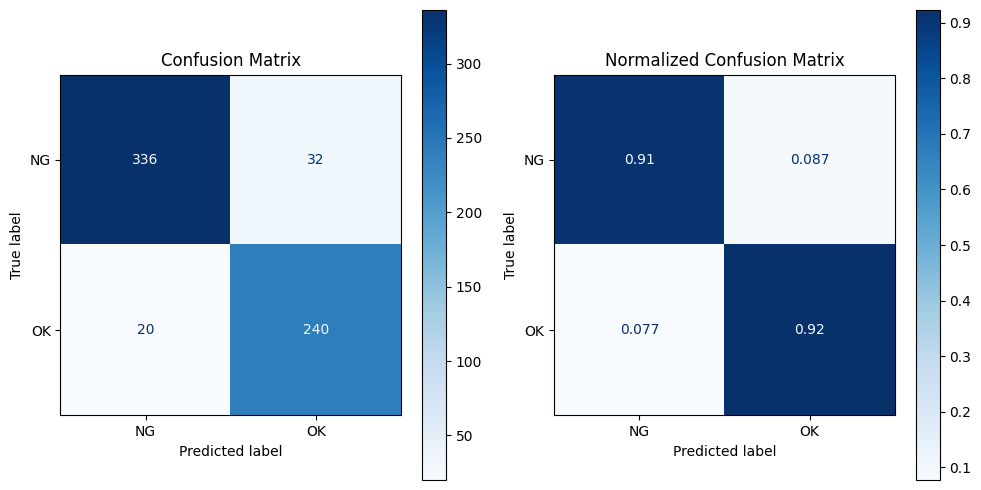

In [324]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

In [325]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
import numpy as np
import torch

# 정밀도-재현율 곡선 그리기 함수
def precision_recall_curve_plot(y_test, prediction_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, prediction_proba_class1)
    
    # 그래프 크기 설정
    plt.figure(figsize=(8, 6))
    
    # 정밀도와 재현율 플롯
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

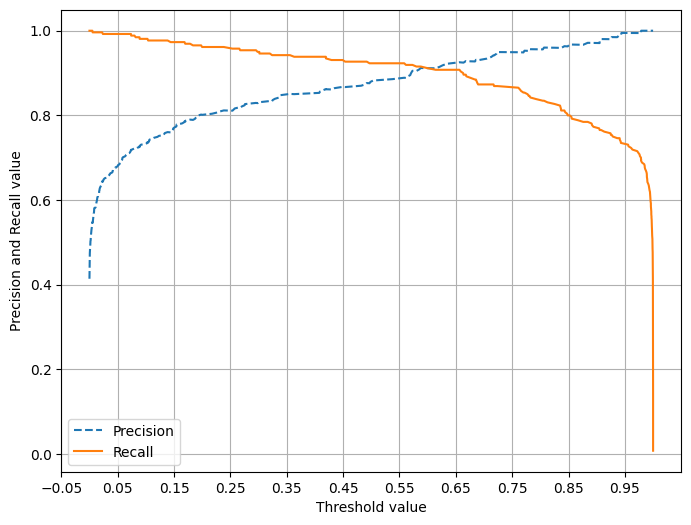

In [326]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [327]:
from sklearn.metrics import precision_recall_curve
import torch
import numpy as np

# 모델이 예측한 확률 값을 얻는 함수
def get_predictions_proba(model, test_loader):
    model.eval()
    all_predictions_proba = []
    all_targets = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, targets in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            
            # 예측 확률 계산 (sigmoid로 확률 변환)
            predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
            all_predictions_proba.extend(predicted_proba)
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions_proba), np.array(all_targets)

In [328]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[7.18605904e-08 5.27541579e-06 5.30140960e-06 8.11261543e-06
 9.91349589e-06 1.08075365e-05 1.43582602e-05 1.58973817e-05
 1.66386417e-05 3.01290893e-05 3.05598514e-05 3.27020498e-05
 3.38175596e-05 3.38611899e-05 3.46010456e-05 3.46390116e-05
 4.25373910e-05 4.44123434e-05 4.63847391e-05 4.94198684e-05
 4.97071414e-05 5.16119835e-05 5.16400469e-05 5.92361612e-05
 6.14641613e-05 6.41321894e-05 6.47687921e-05 6.59984362e-05
 6.68095381e-05 7.41943732e-05 7.70697807e-05 8.29956916e-05
 9.64475985e-05 9.70195106e-05 1.01757840e-04 1.09815606e-04
 1.18054319e-04 1.24795959e-04 1.34098940e-04 1.34903588e-04
 1.43992962e-04 1.60243449e-04 1.62556331e-04 1.97507921e-04
 2.00468261e-04 2.05837961e-04 2.06415571e-04 2.11190520e-04
 2.20642323e-04 2.33875020e-04 2.38412103e-04 2.44956434e-04
 2.51848891e-04 2.67833704e-04 2.87371717e-04 3.19993938e-04
 3.24652763e-04 3.25017550e-04 3.28084046e-04 3.46043205e-04
 3.62585735e-04 3.74066876e-04 3.79418023e-04 3.86651256e-04
 3.89591063e-04 4.484318

In [329]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation_no_pic(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)


In [330]:
from sklearn.preprocessing import Binarizer

def get_evaluation_by_thresholds(y_test, prediction_proba_class1, thresholds):
    for threshold in thresholds:
        # Binarizer로 예측값을 이진화
        binarizer = Binarizer(threshold=threshold).fit(prediction_proba_class1) 
        custom_prediction = binarizer.transform(prediction_proba_class1).flatten()  # 차원 축소
        
        print('임곗값:', threshold)
        get_evaluation_no_pic(y_test, custom_prediction)  # 평가 함수 호출

In [331]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 7.186059e-08
오차 행렬
[[  1 367]
 [  0 260]]
정확도: 0.4156, 정밀도: 0.4147, 재현율: 1.0000, F1:0.5862, AUC:0.5014
###########################################################################
임곗값: 5.275416e-06
오차 행렬
[[  2 366]
 [  0 260]]
정확도: 0.4172, 정밀도: 0.4153, 재현율: 1.0000, F1:0.5869, AUC:0.5027
###########################################################################
임곗값: 5.3014096e-06
오차 행렬
[[  3 365]
 [  0 260]]
정확도: 0.4188, 정밀도: 0.4160, 재현율: 1.0000, F1:0.5876, AUC:0.5041
###########################################################################
임곗값: 8.112615e-06
오차 행렬
[[  4 364]
 [  0 260]]
정확도: 0.4204, 정밀도: 0.4167, 재현율: 1.0000, F1:0.5882, AUC:0.5054
###########################################################################
임곗값: 9.913496e-06
오차 행렬
[[  5 363]
 [  0 260]]
정확도: 0.4220, 정밀도: 0.4173, 재현율: 1.0000, F1:0.5889, AUC:0.5068
###########################################################################
임곗값: 1.08075365e-05
오차 행렬
[[  6 362]
 [  0 260]]
정확도: 0.4236, 정밀도: 0.4180, 재현율:

d:\sy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [332]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

# 평가 함수
def get_evaluation_by_custom_proba(y_test, prediction, visualize=False):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 80)
    
    if visualize:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[349  19]
 [ 24 236]]
정확도: 0.9315, 정밀도: 0.9255, 재현율: 0.9077, F1: 0.9165, ROC-AUC: 0.9280
################################################################################


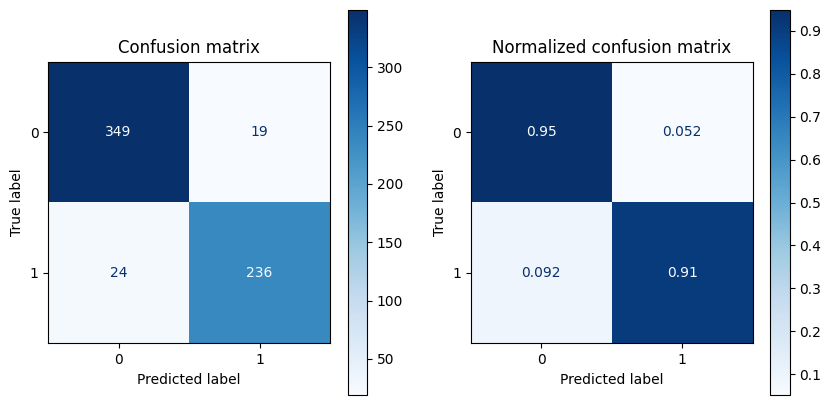

In [335]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.63408005
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

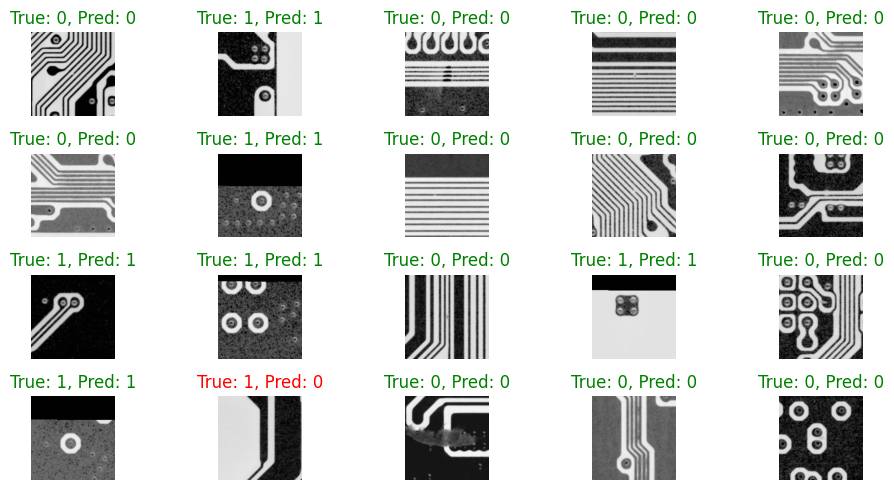

In [339]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# 테스트 데이터셋에서 무작위로 10개의 샘플을 선택하는 함수
def get_random_samples(dataset, num_samples=20):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    return samples, indices

# 이미지 시각화 및 예측 결과 표시
def visualize_predictions(model, dataset, num_samples=20):
    # 모델을 평가 모드로 전환
    model.eval()
    
    # 무작위로 10개의 샘플 가져오기
    samples, indices = get_random_samples(dataset, num_samples=num_samples)
    
    fig, axs = plt.subplots(4, 5, figsize=(10, 5))
    axs = axs.ravel()
    
    with torch.no_grad():
        for i, (image, label) in enumerate(samples):
            # 이미지와 레이블 준비
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            label = label.item()
            
            # 예측 수행
            output = model(image_input)
            pred = torch.sigmoid(output).item()
            pred_label = 1 if pred > 0.5 else 0
            
            # 이미지를 numpy로 변환하여 시각화
            image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
            
            # 정답/오답에 따른 레이블 색상 결정
            if pred_label == label:
                color = 'green'  # 정답일 때 녹색
            else:
                color = 'red'  # 오답일 때 빨간색

            # 이미지 및 레이블 출력
            axs[i].imshow(image_np)
            axs[i].set_title(f"True: {label}, Pred: {pred_label}", color=color)
            axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 무작위 10개 샘플 예측 및 시각화
visualize_predictions(model, test_dataset)

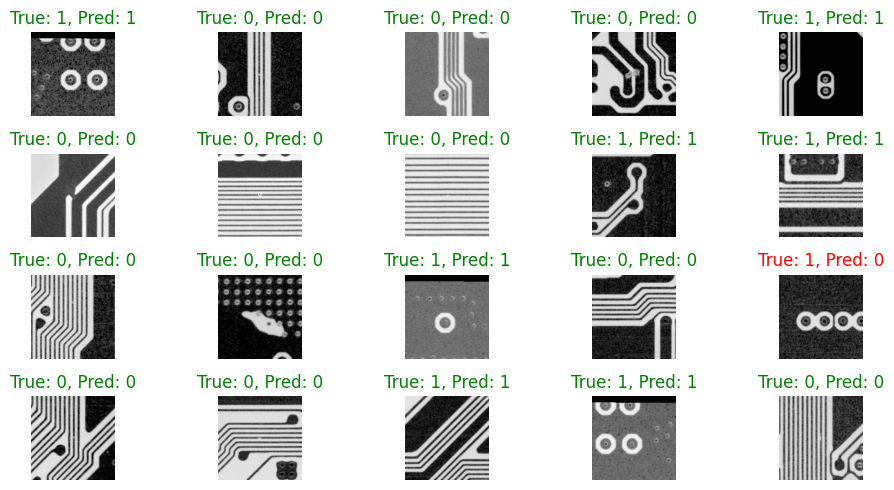

In [240]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# 테스트 데이터셋에서 무작위로 10개의 샘플을 선택하는 함수
def get_random_samples(dataset, num_samples=20):
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    return samples, indices

# 이미지 시각화 및 예측 결과 표시
def visualize_predictions(model, dataset, num_samples=20):
    # 모델을 평가 모드로 전환
    model.eval()
    
    # 무작위로 10개의 샘플 가져오기
    samples, indices = get_random_samples(dataset, num_samples=num_samples)
    
    fig, axs = plt.subplots(4, 5, figsize=(10, 5))
    axs = axs.ravel()
    
    with torch.no_grad():
        for i, (image, label) in enumerate(samples):
            # 이미지와 레이블 준비
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            label = label.item()
            
            # 예측 수행
            output = model(image_input)
            pred = torch.sigmoid(output).item()
            pred_label = 1 if pred > 0.5 else 0
            
            # 이미지를 numpy로 변환하여 시각화
            image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
            
            # 정답/오답에 따른 레이블 색상 결정
            if pred_label == label:
                color = 'green'  # 정답일 때 녹색
            else:
                color = 'red'  # 오답일 때 빨간색

            # 이미지 및 레이블 출력
            axs[i].imshow(image_np)
            axs[i].set_title(f"True: {label}, Pred: {pred_label}", color=color)
            axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 무작위 10개 샘플 예측 및 시각화
visualize_predictions(model, test_dataset)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# k-Fold 설정
k_folds = 5  # 원하는 fold 수
kf = KFold(n_splits=k_folds, shuffle=True, random_state=124)

# 성능 저장을 위한 리스트 초기화
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

# k-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터셋 분리
    train_subset = CustomDataset(train_df.iloc[train_idx]['file_paths'].values, 
                                 train_df.iloc[train_idx]['targets'].values, 
                                 aug=aug)
    val_subset = CustomDataset(train_df.iloc[val_idx]['file_paths'].values, 
                               train_df.iloc[val_idx]['targets'].values)
    
    # DataLoader 설정
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
    
    # 모델 초기화
    model = CustomModel(model_name='resnet50').to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 각 fold에 대해 학습 진행
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for images, targets in train_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # 손실 계산
            loss = criterion(outputs.view(-1), targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 정확도 계산
            predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
        
        train_accuracy = correct_predictions / total_predictions
        fold_train_losses.append(running_loss / len(train_loader))
        fold_train_accuracies.append(train_accuracy)
        
        # 검증
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_accuracy)
        
        # 학습률 스케줄러 적용
        scheduler.step(val_loss)
        
        # 조기 종료 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # 개선 시 카운터 리셋
        else:
            patience_counter += 1  # 개선 없을 시 카운터 증가
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    print(f'Fold {fold + 1} completed. Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# k-Fold 결과 평균 계산
print(f'\n{k_folds}-Fold Cross Validation Results:')
print(f'Average Train Loss: {np.mean(fold_train_losses):.4f}')
print(f'Average Train Accuracy: {np.mean(fold_train_accuracies):.4f}')
print(f'Average Val Loss: {np.mean(fold_val_losses):.4f}')
print(f'Average Val Accuracy: {np.mean(fold_val_accuracies):.4f}')

Fold 1/5


#### resnet50 결과  
- 데이터 증강x, 10 epoch  
훈련 데이터에 과적합된 모델임을 확인.  
Epoch [10/10], Train Loss: 0.0274, Train Accuracy: 99.00%, Validation Loss: 0.3092, Validation Accuracy: 92.03%  

- 데이터 증강o, 10 epoch  
과적합은 없어졌으나 정확도가 0.8정도로 높지 않은 것을 확인.  
Epoch [10/10], Train Loss: 0.4159, Train Accuracy: 0.8093, Val Loss: 0.3668, Val Accuracy: 0.8426  

- 데이터 증강o, 20 epoch, early stopping(patience:3)  
이전과 거의 비슷한 모델임을 확인.  
Epoch [15/20], Train Loss: 0.3826, Train Accuracy: 0.8142, Val Loss: 0.3764, Val Accuracy: 0.8367  

- 데이터 증강o, 20 epoch, early stopping(patience:3), Learning Rate Scheduler(patience:3)  
정확도가 0.9정도로 상승하였고, 학습하면서 손실률이 감소하는 형태인 것으로 보아 과적합의 위험은 낮은 것으로 확인.  
모델이 더 충분한 학습을 할 수 있도록 early stopping의 patience를 10으로 두고 epoch는 50으로 두기로 함.  
Epoch [17/20], Train Loss: 0.2166, Train Accuracy: 0.9014, Val Loss: 0.2723, Val Accuracy: 0.9104  

- 데이터 증강o, 50 epoch, early stopping(patience:10), Learning Rate Scheduler(patience:3)  
정확도와 손실률 모두 이전과 크게 다르지 않은 모델임을 확인함.  
정확도: 0.92 모델이 과적합없이 훈련되었음.  
Epoch [46/50], Train Loss: 0.1719, Train Accuracy: 0.9253, Val Loss: 0.2788, Val Accuracy: 0.9143  

- 해당 모델로 테스트 이미지를 통해 실제 예측을 진행해보았을 때, 20개중 19개를 맞게 분류한 것을 확인.

#### resnet50 모델 fine-tuning 적용
- fine-tuning을 적용하는 이유?  
미세조정을 하면 일부 층은 freezing을 진행하게 된다. 성능은 하락할 위험이 있지만 학습속도가 개선될 수 있다.  
미세조정 목표로는 최소한의 성능하락과 최대화된 학습속도 개선을 목표로 한다.  

In [242]:
import torch.optim as optim

# 모델 생성
model = CustomModel(model_name='resnet50').to(DEVICE)

# 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 새로 추가된 분류기 레이어만 학습
optimizer = optim.Adam(model.fc1.parameters(), lr=0.001)  # 분류기 레이어의 파라미터만 옵티마이저에 전달

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [244]:
EPOCHS = 10

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 3  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/10], Train Loss: 0.5060, Train Accuracy: 0.7660, Val Loss: 0.4648, Val Accuracy: 0.7749
Validation loss improved, saving model...
Epoch [2/10], Train Loss: 0.4747, Train Accuracy: 0.7722, Val Loss: 0.4325, Val Accuracy: 0.7829
Validation loss improved, saving model...
Epoch [3/10], Train Loss: 0.4476, Train Accuracy: 0.7785, Val Loss: 0.4198, Val Accuracy: 0.7888
Epoch [4/10], Train Loss: 0.4572, Train Accuracy: 0.7772, Val Loss: 0.4198, Val Accuracy: 0.8028
Validation loss improved, saving model...
Epoch [5/10], Train Loss: 0.4317, Train Accuracy: 0.7928, Val Loss: 0.4030, Val Accuracy: 0.7869
Validation loss improved, saving model...
Epoch [6/10], Train Loss: 0.4108, Train Accuracy: 0.8071, Val Loss: 0.3921, Val Accuracy: 0.7948
Epoch [7/10], Train Loss: 0.4089, Train Accuracy: 0.8027, Val Loss: 0.3947, Val Accuracy: 0.7948
Validation loss improved, saving model...
Epoch [8/10], Train Loss: 0.4030, Train Accuracy: 0.8071, Val Loss: 0

사전 훈련된 가중치는 고정하고 새로운 층만 학습시킨 1차 fine tuning 결과:  
정확도 0.8정도. 소요 시간은 확실히 많이 줄어든 것을 확인.  
Epoch [10/10], Train Loss: 0.4004, Train Accuracy: 0.7978, Val Loss: 0.3735, Val Accuracy: 0.8167  

다음으로는 전체 모델의 일부를 학습 가능하게 하고자함.  

In [245]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [252]:
import torchvision.models as models

# ResNet50 사전 학습된 모델 로드
model = models.resnet50(weights='IMAGENET1K_V1')

# 모델의 레이어 이름과 모듈 확인
for name, layer in model.named_children():
    print(f"Layer Name: {name}, Layer Type: {layer}")

Layer Name: conv1, Layer Type: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Layer Name: bn1, Layer Type: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer Name: relu, Layer Type: ReLU(inplace=True)
Layer Name: maxpool, Layer Type: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Layer Name: layer1, Layer Type: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample)

In [265]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if 'layer4.2' in name:  # layer4의 마지막 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용
# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [264]:
# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 3  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/10], Train Loss: 0.6865, Train Accuracy: 0.5725, Val Loss: 0.6805, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [2/10], Train Loss: 0.6757, Train Accuracy: 0.5831, Val Loss: 0.6721, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [3/10], Train Loss: 0.6665, Train Accuracy: 0.5899, Val Loss: 0.6635, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [4/10], Train Loss: 0.6577, Train Accuracy: 0.5999, Val Loss: 0.6566, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [5/10], Train Loss: 0.6512, Train Accuracy: 0.6036, Val Loss: 0.6470, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [6/10], Train Loss: 0.6489, Train Accuracy: 0.6105, Val Loss: 0.6395, Val Accuracy: 0.5876
Validation loss improved, saving model...
Epoch [7/10], Train Loss: 0.6405, Train Accuracy: 0.6192, Val Loss: 0.6286, Val Accuracy: 0.6215
Validation loss improved, s

In [266]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6859, Train Accuracy: 0.5544, Val Loss: 0.6727, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.6678, Train Accuracy: 0.5949, Val Loss: 0.6631, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.6607, Train Accuracy: 0.6067, Val Loss: 0.6513, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.6538, Train Accuracy: 0.6105, Val Loss: 0.6384, Val Accuracy: 0.5857
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.6414, Train Accuracy: 0.6322, Val Loss: 0.6243, Val Accuracy: 0.6195
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.6281, Train Accuracy: 0.6801, Val Loss: 0.6130, Val Accuracy: 0.6932
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.6227, Train Accuracy: 0.6839, Val Loss: 0.5988, Val Accuracy: 0.7351
Validation loss improved, s

In [267]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 마지막 bottleneck 블록 하나 동결 해제
for name, param in model.base_model.named_parameters():
    if 'layer4.2' in name:  # layer4의 3번째 bottleneck 블록
        param.requires_grad = True
    if 'layer4.1' in name:  # layer4의 2번째 bottleneck 블록
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용
# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [268]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6771, Train Accuracy: 0.5856, Val Loss: 0.6645, Val Accuracy: 0.5876
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.6678, Train Accuracy: 0.5961, Val Loss: 0.6502, Val Accuracy: 0.5936
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.6531, Train Accuracy: 0.6304, Val Loss: 0.6348, Val Accuracy: 0.6255
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.6399, Train Accuracy: 0.6484, Val Loss: 0.6253, Val Accuracy: 0.6375
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.6319, Train Accuracy: 0.6453, Val Loss: 0.6131, Val Accuracy: 0.6693
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.6212, Train Accuracy: 0.6745, Val Loss: 0.6003, Val Accuracy: 0.7171
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.6127, Train Accuracy: 0.6851, Val Loss: 0.5890, Val Accuracy: 0.7351
Validation loss improved, s

마지막 블록을 unfreeze하였으나 모델 정확도가 0.8정도였음.  
사전학습모델과 이미지가 많이 달라서 일 수 있음. -> 차라리 앞쪽 블록을 unfreeze 해보자.

In [ ]:
# 모델 정의
model = CustomModel(model_name='resnet50').to(DEVICE)

# 1. 사전 학습된 레이어 동결
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. 앞쪽 블록을 unfreeze
for name, param in model.base_model.named_parameters():
    if "layer1" in name :
        param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)  # 낮은 학습률 사용

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

In [ ]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 10  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

#### 정밀도, 재현율 알아보기

클래스={NG, OK}  

True Positive(TP): 모델이 NG를 NG로 올바르게 분류한 경우  
False Positive(FP): 모델이 OK를 NG로 잘못 분류한 경우(error 1)  
True Negative(TN): 모델이 OK를 OK로 올바르게 분류한 경우  
False Negative(FN): 모델이 NG를 OK로 잘못 분류한 경우(error 2)  

정밀도(Precision): 모델이 NG로 예측했을 때, 실제로 NG인 비율  
재현율(Recall): 실제 NG인 이미지 중에 모델이 NG를 정확히 예측한 이미지의 비율. 즉, 모델이 NG를 얼마나 놓치지 않고 예측했는지를 의미.    
- error2가 error1보다 훨씬 나쁘다. 따라서 임계치를 낮춰 재현율을 높이는 것이 적합하다.  